Code modified from models/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb of github.com/tensorflow/

## Imports

In [2]:
import os
import pathlib

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import glob
import numpy as np

import tensorflow as tf

from object_detection.utils import config_util
from object_detection.builders import model_builder

import utils 

%matplotlib inline

# Pretrained model

In [4]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = '../models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '../models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Cat and Dog dataset from stanford

In [6]:
import glob

In [7]:
dog_class_id = 1
num_classes = 1
label_id_offset = 1
category_index = {dog_class_id: {'id': dog_class_id, 'name': 'dog'}}

tf.Tensor([[0.003003  0.362     0.7267267 0.794    ]], shape=(1, 4), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


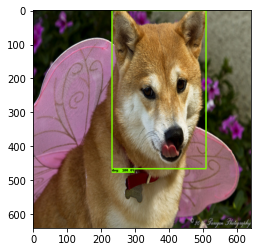

In [8]:
import xml.etree.ElementTree as ET

dataset_path = "data/oxford-pet"
def read_annotation(im_name):
    '''
    Extract the anotation of the image.
    return an array of the form: [[ymin, xmin, ymax, xmax]], as an image may have
    several bounding boxes in the general case.
    The coordonate are proportionate to the length of the corresponding side
    '''
    annotation_path = os.path.join(dataset_path, "annotations", "xmls", f"{im_name}.xml")
    tree = ET.parse(annotation_path)
    bndbox = tree.getroot().find("object").find("bndbox")
    height = float(tree.getroot().find("size").find("height").text)
    width = float(tree.getroot().find("size").find("width").text)
    bdbox_coord = ["ymin", "xmin","ymax","xmax"]
    dims = [height, width, height, width]
    box = [float(bndbox.find(coord).text) / dim for coord,dim in zip(bdbox_coord,dims)]
    return np.array([box])

def get_im_path(im_name):
    return os.path.join(dataset_path, "images", f"{im_name}.jpg")

def get_dog_dataset(batch_size=2, im_size=()):
    '''
    Return the training dataset as a tensorflow.data.Dataset
    '''
    
    paths = glob.glob(get_im_path("[a-z]*"))
    names = [os.path.basename(p)[:-4] for p in paths]
    names = [n for  n in names if os.path.isfile(os.path.join(dataset_path, "annotations", "xmls", f"{n}.xml"))]
    bounding_boxes = [read_annotation(name) for name in names]
    name_label_list = list(zip(names,bounding_boxes))
    
    def _generator():
        '''
        Read on example.
        Preprocess it according to detection_model.preprocess
        '''
        np.random.shuffle(name_label_list)
        for name,y in name_label_list:
            np_image = utils.load_image_into_numpy_array(get_im_path(name))
            tf_image = tf.expand_dims(tf.convert_to_tensor(np_image, dtype=tf.float32), axis=0)
            preprocessed_image = detection_model.preprocess(tf_image)[0][0]
            
            
            gt_box_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
            
            zero_indexed_groundtruth_classes = tf.convert_to_tensor(
                    np.ones(shape=[gt_box_tensor.shape[0]], dtype=np.int32) - label_id_offset)
            
            gt_classes_one_hot_tensor = tf.one_hot(
                  zero_indexed_groundtruth_classes, num_classes)
            
            yield preprocessed_image, gt_box_tensor, gt_classes_one_hot_tensor

    dataset = tf.data.Dataset.from_generator(_generator, (tf.float32, tf.float32, tf.float32))
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

def test_dataset():
    '''
    Make sure that we are generating a good dataset, by displaying one example.
    '''
    for x,y,z in get_dog_dataset(batch_size=4).take(1):
        pass
    box = y[0].numpy()
    dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
    np_image = x[0].numpy()
    np_image = (np_image - np.min(np_image, axis=(0,1), keepdims=True)) / (np.max(np_image, axis=(0,1), keepdims=True)-np.min(np_image, axis=(0,1), keepdims=True)) 
    utils.plot_detections(
          np.array(np_image*255, dtype=np.int),
          box,
          np.ones(shape=[box.shape[0]], dtype=np.int32),
          dummy_scores, category_index)
    print(y[0])
    print(z[0])
    
test_dataset()

# Eager model custom training loop



In [10]:
import tqdm.notebook as tqdm

In [11]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  #@tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):

    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      prediction_dict = model.predict(image_tensors, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, 
                                              optimizer, to_fine_tune)
checkpoint = tf.train.Checkpoint(model=detection_model)

print('Start fine-tuning!', flush=True)
count = 0
for i in range(4):
    for im, box, label in tqdm.tqdm(get_dog_dataset()):
        # Training step (forward pass + backwards pass)
        total_loss = train_step_fn(im, box, label)

        count += 1
        if count % 200 == 0:
            print('batch ' + str(count) 
            + ', loss=' +  str(total_loss.numpy()), flush=True)
    #Uncomment following line to save the model
    #print(checkpoint.save('models/detection/checkpoints/dog-finetuned-checkpoint'))

print('Done fine-tuning!')

Start fine-tuning!


batch 200, loss=1.4957011
batch 400, loss=2.0098014
batch 600, loss=1.0494072
batch 800, loss=0.88287896
batch 1000, loss=1.755124
batch 1200, loss=1.5597899



batch 1400, loss=1.0894119
batch 1600, loss=2.9945667
batch 1800, loss=2.1785693
batch 2000, loss=1.5400453
batch 2200, loss=1.30984
batch 2400, loss=1.9139487

Done fine-tuning!


# Test on new image

In [13]:
checkpoint.restore('models/detection/checkpoints/dog-finetuned-checkpoint-2')

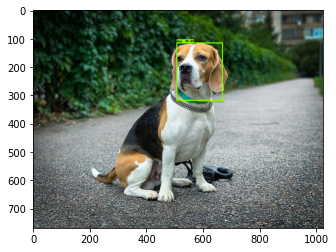

In [14]:
test_image_path = "data/dogs-1024/50562567067.jpg"
test_image_np = np.expand_dims(utils.load_image_into_numpy_array(test_image_path), axis=0)

@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

input_tensor = tf.convert_to_tensor(test_image_np, dtype=tf.float32) 
detections = detect(input_tensor)

utils.plot_detections(
    test_image_np[0],
    detections['detection_boxes'][0].numpy(),
    detections['detection_classes'][0].numpy().astype(np.uint32)
    + label_id_offset,
    detections['detection_scores'][0].numpy(),
    category_index, figsize=(15, 20))